In [1]:
import mglearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# カーネル法を用いたサポートベクタマシン

カーネル法を用いたサポートベクタマシン（SVM）は入力空間の超平面のような簡単なモデルではなく、より複雑なモデルを可能にするために線形サポートベクタマシンを拡張したものである<br>
クラス分類にも回帰にも使用できるがSVCとして実装されているクラス分類にだけ記載する<br>

低次元における線形モデルは非常に制約が強い。<br>
線形モデルを柔軟にする方法の一つとして特徴量の追加がある<br>
例えば、入力特徴量の交互作用（積）や多項式項を加えることが考えられる<br>

Text(0,0.5,'Feature 1')

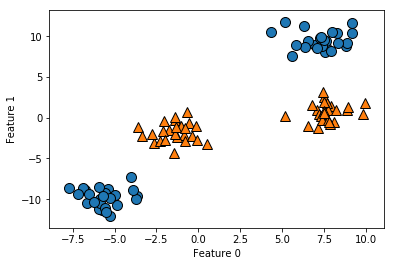

In [3]:
from sklearn.datasets import make_blobs
X,y = make_blobs(centers=4,random_state=8)
y=y%2
mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

線形モデルによるクラス分類では上記のようなデータセットではうまくいかない

Text(0,0.5,'Feature 1')

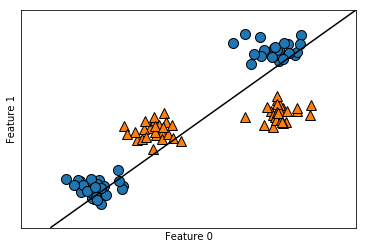

In [4]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X,y)

mglearn.plots.plot_2d_separator(linear_svm,X)
mglearn.discrete_scatter(X[:,0],X[:,1],y)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

上記の通り、全くうまくいっていない<br>
ここで新たな特徴量を増やしてみる<br>
例えばfeature 1 の2乗、つまり2番目の特徴量の2乗を新たな特徴量として加えてみる。<br>
データポイントは(Feature0,Feature1)の2次元の点から(Feature0,Feature1,Feature1**2)の3次元の点となる<br>

Text(0.5,0,'Feature1 ** 2')

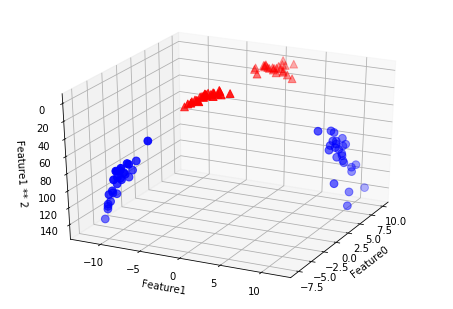

In [8]:
X_new = np.hstack([X,X[:,1:]**2])
from mpl_toolkits.mplot3d import Axes3D,axes3d

figure = plt.figure()
#y==0の点をプロットしてからy==1の点をプロット
ax=Axes3D(figure,elev=-152,azim=-26)
mask = y == 0

ax.scatter(X_new[mask,0],X_new[mask,1],X_new[mask,2],c='b',cmap=mglearn.cm2,s=60)
ax.scatter(X_new[~mask,0],X_new[~mask,1],X_new[~mask,2],c='r',marker='^',cmap=mglearn.cm2,s=60)

ax.set_xlabel("Feature0")
ax.set_ylabel("Feature1")
ax.set_zlabel("Feature1 ** 2")

この新しい表現では２つのクラスを線形モデルで、つまり3次元空間内の平面を用いて分離可能となる。

Text(0.5,0,'Feature1 ** 2')

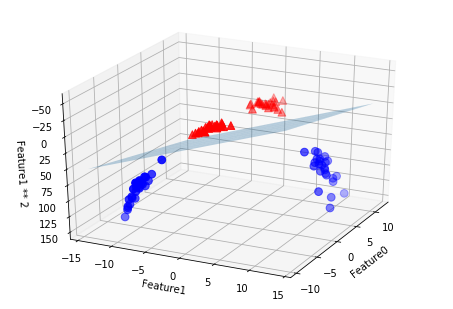

In [10]:
linear_svm_3d = LinearSVC().fit(X_new,y)
coef,intercept = linear_svm_3d.coef_.ravel(),linear_svm_3d.intercept_

figure = plt.figure()
ax = Axes3D(figure,elev=-152,azim=-26)
xx=np.linspace(X_new[:,0].min()-2,X_new[:,0].max()+2,50)
yy=np.linspace(X_new[:,1].min()-2,X_new[:,1].max()+2,50)

XX,YY = np.meshgrid(xx,yy)
ZZ=(coef[0]*XX+coef[1]*YY+intercept)/-coef[2]
ax.plot_surface(XX,YY,ZZ,rstride=8,cstride=8,alpha=0.3)

ax.scatter(X_new[mask,0],X_new[mask,1],X_new[mask,2],c='b',cmap=mglearn.cm2,s=60)
ax.scatter(X_new[~mask,0],X_new[~mask,1],X_new[~mask,2],c='r',marker='^',cmap=mglearn.cm2,s=60)

ax.set_xlabel("Feature0")
ax.set_ylabel("Feature1")
ax.set_zlabel("Feature1 ** 2")

上記のような3次元上でうまく分類できているがもとの特徴量の関数として見ると線形SVMモデルは線形でなくなっている。<br>
直線ではなく楕円となる。<br>

Text(0,0.5,'Feature 1')

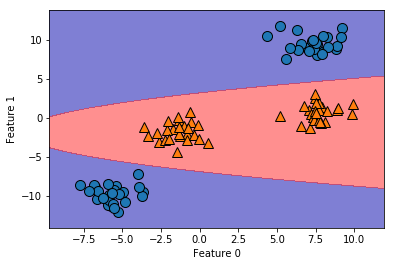

In [11]:
ZZ=YY**2

dec = linear_svm_3d.decision_function(np.c_[XX.ravel(),YY.ravel(),ZZ.ravel()])
plt.contourf(XX,YY,dec.reshape(XX.shape),levels=[dec.min(),0,dec.max()],cmap=mglearn.cm2,alpha=0.5)
mglearn.discrete_scatter(X[:,0],X[:,1],y)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

これらでわかるのは、非線形の特徴量にデータ表現を加えることで線形モデルははるかに強力になる<br>
しかし、実際にはどの特徴量を加えたらよいかわからない。<br>
たくさんの特徴量を加える（100次元の特徴量に対してすべての可能な積を加えるなど）と計算量が大きくなりすぎる。<br>
これに対して非常に大きくなりうる表現を実際に計算せずに、高次元空間でのクラス分類器を学習させる数学的トリックがある<br>
<b>これがカーネルトリック</b>と呼ばれるもので、拡張された特徴表現乗でのデータポイント間の距離を実際にデータポイントの拡張を計算せずに直接計算する方法である<br>
SVMで広く用いられている高次元空間へのマップ方法は2つある。
もとの特徴量の特定の字数までのすべての多項式（feature1 ** 2 * feature2 ** 5など)を計算する多項式カーネル<br>
もう一つは放射基底関数（RBF)カーネルとも呼ばれるガウシアンカーネルである。<br>
ガウシアンカーネルは無限次元の特徴空間に対応するので説明が難しいが、直感的にはガウシアンカーネルではすべての字数のすべての多項式を与えるが次数が高くなるにつれて特徴量の重要性を小さくしている<br>

## SVMを理解する

訓練の過程で、SVMは個々のデータポイントが２つのクラスの決定境界を表現するのにどの程度重要かを学習する。<br>
多くの場合は2つのクラスに位置するごく一部の訓練データポイントだけが決定境界を定める。これらのデータポイントを<b>サポートベクタ</b>と呼ぶ。<br>
<br>
新しいデータポイントに対して予測を行う際にサポートベクタとデータポイントとの距離が測定される。<br>
クラス分類はこのサポートベクタとの距離と訓練過程で学習された個々のサポートベクタの重要性(SVCのdual_coef_属性に格納されている）によって決定される。<br>

次に2次元2クラス分類データセットに対してサポートベクタマシンを学習させた結果を示す。決定境界は黒で描かれており、サポートベクタは大きく縁取りした点で書かれている。<br>

Text(0,0.5,'Feature 1')

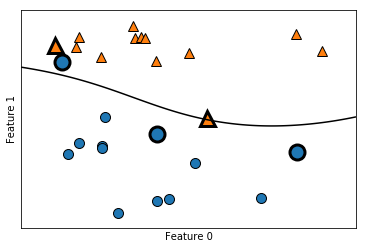

In [15]:
from sklearn.svm import SVC

X,y=mglearn.tools.make_handcrafted_dataset()
svm=SVC(kernel='rbf',C=10,gamma=0.1).fit(X,y)

mglearn.plots.plot_2d_separator(svm,X,eps=.5)
mglearn.discrete_scatter(X[:,0],X[:,1],y)
sv=svm.support_vectors_
sv_labels=svm.dual_coef_.ravel()>0
mglearn.discrete_scatter(sv[:,0],sv[:,1],sv_labels,s=15,markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

この場合SVMによる境界は非常になめらかで非直線である。ここではCとgammaによるパラメタの調整がある

gammaパラメータは前節の式（本参照）に出てきたもので、ガウシアンカーネルの幅を調節する<br>
このパラメータが点が近いということを意味するスケールを決定する。<br>
Cのパラメータは線形モデルで用いられたのと同様に正則化パラメータである<br>

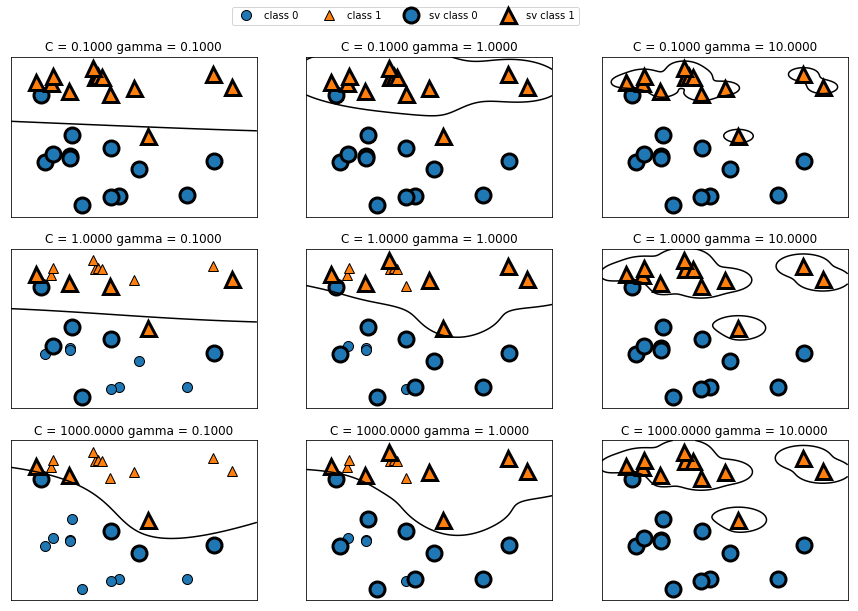

In [18]:
fig ,axes = plt.subplots(3,3,figsize=(15,10))

for ax,C in zip(axes,[-1,0,3]):
    for a,gamma in zip(ax,range(-1,2)):
        mglearn.plots.plot_svm(log_C=C,log_gamma=gamma,ax=a)

axes[0,0].legend(["class 0","class 1","sv class 0","sv class 1"],ncol=4,loc=(.9,1.2))

gammaが小さいとガウシアンカーネルの直径が大きくなり、多くの点を近いと判断するようになる。(右にいくほど太い点が多い）<br>
これによって、左のほうでは決定境界がなめらかになり、右に行くに連れて、個々のデータポイントをより重視するようになっている<br>
gammaが小さい場合には決定境界はゆっくりとしか変化せずモデルの複雑さは小さくなる。gammaが大きくなるとモデルはより複雑になる。<br>
Cは制限されたモデルに対応し、個々のデータポイントの与える影響は限定される。<br>
左上の決定境界を見るとほぼ直線であることからもこれがわかる。クラス分類に失敗したデータポイントもあるが決定境界にはまったく影響を与えていない。Cを大きくすると左下のグラフからもわかるようにデータポイントがより強い影響を持つことになっている。<br>
RBFカーネル法を用いたSVMをcancerデータセットに適用してみる。デフォルトパラメータはC=1,gamma=1/n_featuresとなっている。


In [20]:
cancer = load_breast_cancer()
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0)

svc=SVC()
svc.fit(X_train,y_train)

print("訓練セット:{:.3f}".format(svc.score(X_train,y_train)))
print("検証セット:{:.3f}".format(svc.score(X_test,y_test)))

訓練セット:1.000
検証セット:0.629


訓練セット精度は100%、検証セットは63%なので過剰適合していることがわかる。SVMはうまくいく場合は多いがパラメータの設定とデータのスケールに敏感であるという問題がある<br>
特に、すべての特徴量の変異が同じスケールであることを要求する。個々の特徴量の最大値と最小値を対数でプロットしてみる

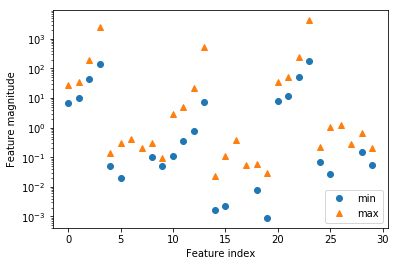

In [22]:
plt.plot(X_train.min(axis=0),'o',label="min")
plt.plot(X_train.max(axis=0),'^',label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

この問題を解決する方法がそれぞれの特徴量をスケール変換する方法である。すべての特徴量が0~1の間の値となるようにスケール変換する方法で、MinMaxScalerで行う。

In [24]:
min_on_training=X_train.min(axis=0)
range_on_training=(X_train - min_on_training).max(axis=0)

X_train_scaled=(X_train - min_on_training) / range_on_training
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n{}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


上記の通りすべての特徴量で最小が0、最大が1となっている

In [27]:
X_test_scaled=(X_test - min_on_training) / range_on_training
svc = SVC()
svc.fit(X_train_scaled,y_train)

print("訓練セット:{:.3f}".format(svc.score(X_train_scaled,y_train)))
print("検証セット:{:.3f}".format(svc.score(X_test_scaled,y_test)))

訓練セット:0.948
検証セット:0.951


データをスケールすることで精度がかなり良くなった。<br>
適合不足に見えるためCやgammaを増やして複雑なモデルにしていく

In [29]:
svc = SVC(C=1000)
svc.fit(X_train_scaled,y_train)

print("訓練セット:{:.3f}".format(svc.score(X_train_scaled,y_train)))
print("検証セット:{:.3f}".format(svc.score(X_test_scaled,y_test)))

訓練セット:0.988
検証セット:0.972


ここではCを大きくすることでモデルは大きく改良された

# 利点、欠点、パラメータ

さまざまなモデルに対してうまく機能する。<br>
SVMを用いるとデータにわずかな特徴量しかない場合でも複雑な決定境界を生成することができる<br>
低次元のデータでも高次元のデータでも（つまり特徴
量が多くても少なくても）うまく機能するが、サンプルの個数が多いとうまくいかない<br>
10000サンプルぐらいならうまく機能するが100000ぐらいになると実行時やメモリ使用量の面で難しくなってくる<br>

SVMの問題点は注意深くデータの前処理とパラメータ調整を行う必要があることだ。<br>
多くのアプリケーションで勾配ブースティングなどの（ほとんど、もしくはまったく前処理が不要な）決定木ベースのモデルのほうが用いられているのはこのためである。さらにSVMのモデルは検証が難しく、予測がされた理由を理解することが難しく、モデルを専門家以外に説明するのが大変<br>

しかし特徴量が似た測定器の測定結果（例えばカメラのピクセルなど）のように同じスケールになる場合には試して見る価値はある<br>
カーネル法を用いたSVMで重要なパラメータは正則化パラメータC、カーネルの選択、カーネル固有のパラメータである<br>
ここではRBFカーネルを用いたがscikit-learnには他のカーネルも容易されている。<br>
RBFカーネルのパラメータはガウシアンカーネルの幅の逆数を表すgammaだけである。<br>
gammmaとCは両方ともモデルの複雑さを制御するパラメータで大きくするとより複雑なモデルになる。<br>
つまり2つのパラメータの設定は強く相関するため両方を同時に調整する必要がある